In [1]:
import sys
sys.path.append('/Users/spindicate/Documents/programming/zooscraper/')

import django
django.setup()

In [2]:
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

%load_ext autoreload
%autoreload 2

In [3]:
from datetime import datetime as dt
import numpy as np
import pandas as pd
from casestudy.see19 import get_baseframe, CaseStudy

In [4]:
baseframe = get_baseframe()

# SCATTER ANIMATION

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
from matplotlib import transforms
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from PIL import Image, ImageDraw

# FuncAnimation

In [6]:
kwargs = {
    'countries': ['United States of America (the)'],
    'count_dma': 14, 
    'start_hurdle': dt(2020,4,1), 
    'start_factor': 'date', 
    'lognat': True,
}
casestudy = CaseStudy(baseframe, **kwargs)

In [7]:
# Animation Kwargs
inset = {'inset': 'cases_new_dma_per_test_new_dma'}

In [8]:
categories = {'y': 'cases_new_dma_per_1M', 'x': 'tests_new_dma_per_1M', **inset}
df_anime = casestudy.df[['region_name', 'region_code', 'date', 'days', *categories.values()]].sort_values(by=['region_name', 'date'])

df_anime = df_anime.copy(deep=True)

## Sort by maximum cases
sort_by = 'cases'
maxes = {region_name: df_g['{}_new_dma_per_1M'.format(sort_by)].max() for region_name, df_g in df_anime.groupby('region_name')}
regions_by_maxes = [region for region, maxi in sorted(maxes.items(), key=lambda t: t[1])]
df_anime.region_name = pd.Categorical(df_anime.region_name, regions_by_maxes)
df_anime = df_anime.sort_values(by=['region_name', 'days'])
df_anime = df_anime[df_anime.region_name.isin(df_anime.region_name.unique()[-2:])]
df_anime = df_anime.dropna(how='any')

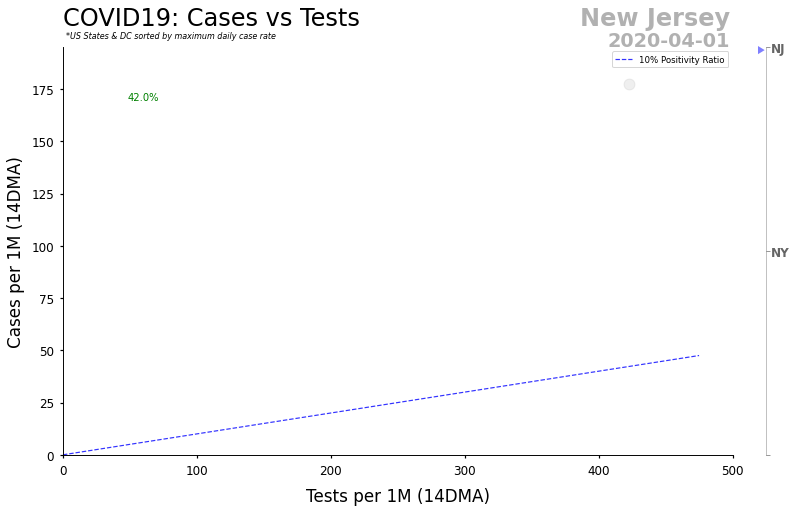

In [46]:
from matplotlib import pyplot as plt
from matplotlib.patches import Patch, Polygon, Circle, Rectangle
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

w=12
fig, ax = plt.subplots(figsize=(w, w/1.6))

titletext = ax.text([0], [0], 'COVID19: Cases vs Tests', 
    size=w*2,
    ha='left',
    va='top',
)
focustext = ax.text([0], [0], '*US States & DC sorted by maximum daily {} rate'.format(sort_by[:-1]), 
    size=w/1.5,
    ha='left',
    va='top',
    style='italic',
)
region_abbreviations = df_anime.region_code.unique()[::-1].tolist()
ax.tick_params(axis='both', labelsize=w, pad=w/2, length=w/4, width=w/10)
ax.set_xlabel('Tests per 1M (14DMA)', labelpad=w/1.2, fontsize=w*1.4)
ax.set_ylabel('Cases per 1M (14DMA)', labelpad=w/2, fontsize=w*1.4)

dots = plt.scatter([0], [0], marker='o', s=w*10, zorder=2)
lines, = plt.plot([0], [0], c='grey', alpha=0.5, zorder=1)
tenper, = plt.plot([0], [0], color='b', linestyle='--', linewidth=w/10, alpha=.8)
regiontext = ax.text(0, 0, '', size=w*2, alpha=.3, fontweight='bold', ha='right', va='top')
datetext = ax.text(0, 0, '', size=w*1.6, alpha=.3, fontweight='bold', ha='right', va='top')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

legend_elements = [Line2D([0], [30], color='b', lw=w/10, ls='--', alpha=.8, label='10% Positivity Ratio')]
ax.legend(handles=legend_elements, loc='upper right', prop={'size': w/1.4})

timeline = ax.twinx()
timeline.spines['right'].set_position(('axes', 1.05))
timeline.spines['right'].set_alpha(.3)
timeline.spines['top'].set_visible(False)
timeline.set_yticks(range(len(region_abbreviations) + 1))
timeline.set_yticklabels([''] + region_abbreviations, alpha=.6, fontweight='bold')
timeline.tick_params(axis='y', labelsize=w, pad=w/10, color='grey')

triangle = Polygon(((0,0), (0,0), (0, 0)), fc='b', alpha=.5, clip_on=False)
ax.add_patch(triangle)

# INSET!
left, bottom, width, height = [0.20, 0.65, 0.2, 0.2]
axin = fig.add_axes([left, bottom, width, height])
insetline, = plt.plot([0], [0], '-', c='green', )
insetannot = axin.annotate('', xy=(0,0), xytext=(0,0), c='green', size=w/1.2, va="center")
axin.axis('off')

index_of_last_region_rows = [df_g.index[-1] for i, df_g in df_anime.groupby('region_name', observed=True)]
completed_regions_index = []
def snap(i):
#     global df_anime
#     global completed_regions_index
#     global index_of_last_region_rows
    
    df_snap = df_anime.iloc[:i]
    current_region = df_snap.region_name.iloc[-1]
    df_reg = df_anime[df_anime.region_name == current_region]
    
    # Set Colors
    rgba_colors = np.zeros((df_snap.shape[0], 4))
    
    if completed_regions_index:
        completed_length = df_snap.loc[:completed_regions_index[-1]].shape[0]
        # for red the first column needs to be one
        rgba_colors[:completed_length, [0,1,2]] = .4
        rgba_colors[:completed_length, 3] = .1

        alphas = np.linspace(0.1, 1, df_snap.shape[0] - completed_length)
        rgba_colors[completed_length:, 0] = 1
        rgba_colors[completed_length:, 3] = alphas
    else:
        alphas = np.linspace(0.01, 1, df_snap.shape[0])
        # for red the first column needs to be one
        rgba_colors[:,0] = 1
        # the fourth column needs to be your alphas
        rgba_colors[:, 3] = alphas
    
    colors = rgba_colors
    x = df_snap[categories['x']]
    y = df_snap[categories['y']]
    
    data = np.hstack((x[:,np.newaxis], y[:, np.newaxis]))
    dots.set_offsets(data)
    dots.set_color(colors)
    lines.set_data(x, y)

    xlim = x.max()*1.03 if x.max() > 500 else 500
    ylim = y.max()*1.1 if y.max() > 100 else 100
    
    # 10% Threshold
    thresh1 = xlim*.95 if xlim*.1 <= ylim else ylim*10*.95
    x_fit = np.linspace(0, thresh1, 20, endpoint=True)
    y_fit = x_fit * .1

    tenper.set_data(x_fit, y_fit)
    
    dots.axes.set_xlim(0, xlim)
    dots.axes.set_ylim(0, ylim)
    
    regiontext.set_text(current_region)
    regiontext.set_position((xlim*0.9963, ylim*1.1))
    
    date_str = df_snap.date.iloc[-1].strftime('%Y-%m-%d')
    datetext.set_text(date_str)
    datetext.set_position((xlim*0.9963, ylim*1.04))
    
    titletext.set_position((0, ylim*1.1))
    focustext.set_position((xlim*.005, ylim*1.04))
    
    # Timeline Triangle Animation
    tri_pos = ylim * (i / df_anime.shape[0])
    tri_xwidth = .01
    tri_ywidth = .02
    x1 = x3 = xlim*1.038
    x2 = xlim*(1.038 + tri_xwidth)
    y1 = (ylim*(1 + tri_ywidth / 2) - tri_pos)
    y2 = (ylim*(1 + tri_ywidth / 2) - tri_pos) - (ylim * tri_ywidth / 2)
    y3 = (ylim*(1 + tri_ywidth / 2) - tri_pos) - (ylim * tri_ywidth)
    tri_xy = ((x1, y1), (x2, y2), (x3, y3))
    triangle.set_xy(tri_xy)
    
    # Positivity Rate
    df_regsnap = df_snap[df_snap.region_name == current_region]
    x_posy = df_regsnap.days.dt.days
    y_posy = df_regsnap[categories['inset']]
    insetline.set_data(x_posy, y_posy)
    insetline.axes.set_xlim(x_posy.min(), df_anime.date.iloc[-1])
    insetline.axes.set_ylim(df_reg[categories['inset']].min()*.5, df_reg[categories['inset']].max()*1.1)
    insetline.set_markevery([-1])
    insetannot.set_text('{:.1%}'.format(y_posy.iloc[-1]))
    insetannot.set_position((x_posy.iloc[-1]*2, y_posy.iloc[-1]))
    insetannot.xy = (x_posy.iloc[-1], y_posy.iloc[-1])

    if df_snap.index[-1] in index_of_last_region_rows:
        completed_regions_index.append(index_of_last_region_rows.pop(0))
    
    return dots, lines, tenper, titletext, regiontext, datetext, insetline

anime = FuncAnimation(fig, snap, blit=False, 
    frames=np.arange(1, df_anime.shape[0] + 1), 
    interval=80, repeat=False
)   
        
from IPython.display import HTML
HTML(anime.to_html5_video())

# anime.save('/Users/spindicate/Documents/docs/covid19/charts/Cases v Tests in {} US States - {} Sort {}DMA{}.mp4'.format(df_anime.region_name.unique().shape[0], sort_by.capitalize(), casestudy.count_dma, ' - TWEET' if w==8 else ''))

## Multiple Y-Axes

In [9]:
categories = {'y': 'cases_new_dma_per_1M', 'y2': 'cases_new_dma_per_test_new_dma', 'x': 'days'}
df_anime = casestudy.df[['region_name', 'region_code', 'date', *categories.values()]].sort_values(by=['region_name', 'days'])

# df_anime = df_anime.copy(deep=True)
# sort_by = 'cases'
# df_anime = df_anime.sort_values(by=['region_name', 'days'])
# df_anime.days = df_anime.days.dt.days
# df_anime = df_anime[df_anime.region_name.isin(df_anime.region_name.unique()[-5:])]

## Sort by maximum cases
sort_by = 'cases'
maxes = {region_name: df_g[categories['y'].format(sort_by)].max() for region_name, df_g in df_anime.groupby('region_name')}
regions_by_maxes = [region for region, maxi in sorted(maxes.items(), key=lambda t: t[1])]
df_anime.region_name = pd.Categorical(df_anime.region_name, regions_by_maxes)
df_anime = df_anime.sort_values(by=['region_name', 'days'])
df_anime.days = df_anime.days.dt.days
df_anime = df_anime[df_anime.region_name.isin(df_anime.region_name.unique()[-2:])]
df_anime = df_anime.dropna(how='any')

In [10]:
def _add_twinx(ax, ys, y=1.1, alpha=.3):
    twinx = ax.twinx()
    twinx.spines['right'].set_position(('axes', y))
    twinx.spines['right'].set_alpha(alpha)
    twinx.spines['top'].set_visible(False)
    if isinstance(ys[0], str):
        twinx.set_yticks(range(len(ys) + 1))
        twinx.set_yticklabels([''] + ys, alpha=.6, fontweight='bold')
    else:
        twinx.set_yticks(ys)
        twinx.set_yticklabels(ys, alpha=.6, fontweight='bold')

    timeline.tick_params(axis='y', labelsize=w, pad=w/10, color='grey')

    return timeline

In [11]:
from matplotlib import pyplot as plt
from matplotlib.patches import Patch, Polygon, Circle, Rectangle
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

regs = df_anime.region_code.unique()[::-1].tolist()

w=12
fig, ax = plt.subplots(figsize=(w, w/1.6))

titletext = ax.text([0], [0], 'COVID19: Positivity Ratio', 
    size=w*2,
    ha='left',
    va='top',
)
focustext = ax.text([0], [0], '*US States & DC sorted by maximum daily {} rate'.format(sort_by[:-1]), 
    size=w/1.5,
    ha='left',
    va='top',
    style='italic',
)

ax.tick_params(axis='both', labelsize=w, pad=w/2, length=w/4, width=w/10)
ax.set_xlabel('Days', labelpad=w/1.2, fontsize=w*1.4)
ax.set_ylabel('Positivity Ratio', labelpad=w/2, fontsize=w*1.4)

line, = plt.plot([0], [0], '-', c='green', )

timeline = _add_twinx(ax, regs, y=1.1)

y2 = _add_twinx(ax, df_anime[categories['y2']].tolist(), y=1, alpha=.8)

y2.axhline(.1, color='b', linestyle='--', linewidth=w/10, alpha=.8 )
datetext = ax.text(0, 0, '', size=w*1.6, alpha=.3, fontweight='bold', ha='right', va='top')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

index_of_last_region_rows = [df_g.index[-1] for i, df_g in df_anime.groupby('region_name', observed=True)]
completed_regions_index = []
def snap(i):    
    df_snap = df_anime.iloc[:i]
    current_region = df_snap.region_name.iloc[-1]
    df_snap = df_snap[df_snap.region_name == current_region]
        
    x = df_snap[categories['x']]
    y = df_snap[categories['y']]
    
    line.set_data(x, y)

    xlim = x.max()*1.03
    ylim = y.max()*1.1

    ax.set_xlim(0, xlim)
    ax.set_ylim(0, ylim)
        
    date_str = df_snap.date.iloc[-1].strftime('%Y-%m-%d')
    datetext.set_text(date_str)
    datetext.set_position((xlim*0.9963, ylim*1.04))
    
    titletext.set_position((0, ylim*1.1))
    focustext.set_position((xlim*.005, ylim*1.04))
    
    return line, titletext, datetext,

anime = FuncAnimation(fig, snap, blit=False, 
    frames=np.arange(1, df_anime.shape[0] + 1), 
    interval=80, repeat=False
)   
        
from IPython.display import HTML
HTML(anime.to_html5_video())

NameError: name 'timeline' is not defined

TypeError: float() argument must be a string or a number, not 'list'

<Figure size 864x540 with 2 Axes>

# Multiple Lines

/Users/spindicate/Documents/programming/envs/zooenv/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


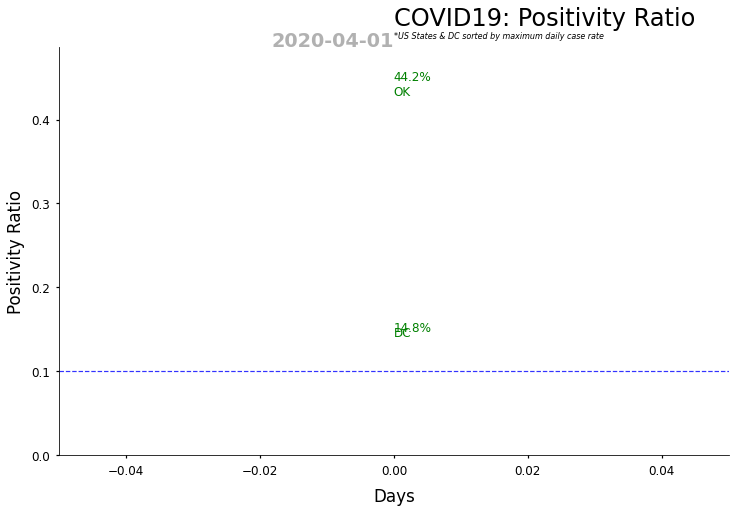

In [26]:
from matplotlib import pyplot as plt
from matplotlib.patches import Patch, Polygon, Circle, Rectangle
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

w=12
fig, ax = plt.subplots(figsize=(w, w/1.6))

titletext = ax.text([0], [0], 'COVID19: Positivity Ratio', 
    size=w*2,
    ha='left',
    va='top',
)
focustext = ax.text([0], [0], '*US States & DC sorted by maximum daily {} rate'.format(sort_by[:-1]), 
    size=w/1.5,
    ha='left',
    va='top',
    style='italic',
)
regs = df_anime.region_code.unique()[::-1].tolist()
ax.tick_params(axis='both', labelsize=w, pad=w/2, length=w/4, width=w/10)
ax.set_xlabel('Days', labelpad=w/1.2, fontsize=w*1.4)
ax.set_ylabel('Positivity Ratio', labelpad=w/2, fontsize=w*1.4)

lines = {}
annots = {}
for reg in regs:
    lines[reg], = plt.plot([0], [0], '-', c='green')

    annots[reg] = {'per': ax.annotate('', xy=(0,0), xytext=(0,0), c='green', size=w, va="center"),
        'name': ax.annotate('', xy=(0,0), xytext=(0,0), c='green', size=w, va="center"),
    }
ax.axhline(.1, color='b', linestyle='--', linewidth=w/10, alpha=.8 )
datetext = ax.text(0, 0, '', size=w*1.6, alpha=.3, fontweight='bold', ha='right', va='top')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

index_of_last_region_rows = [df_g.index[-1] for i, df_g in df_anime.groupby('region_name', observed=True)]
completed_regions_index = []

def snap(i):
    global df_anime
    
    df_snap = df_anime[df_anime.days <= i]
    for reg in regs:
        x_reg = df_snap[df_snap.region_code == reg][categories['x']]
        y_reg = df_snap[df_snap.region_code == reg][categories['y']]
        lines[reg].set_data(x_reg, y_reg)
    
        annots[reg]['per'].set_text('{:.1%}'.format(y_reg.iloc[-1]))
        annots[reg]['per'].set_position((x_reg.iloc[-1]*1.02, y_reg.iloc[-1]*1.02))
        annots[reg]['per'].xy = (x_reg.iloc[-1], y_reg.iloc[-1])
        
        annots[reg]['name'].set_text(reg)
        annots[reg]['name'].set_position((x_reg.iloc[-1]*1.02, y_reg.iloc[-1]*0.98))
        annots[reg]['name'].xy = (x_reg.iloc[-1], y_reg.iloc[-1])
    
    x = df_snap[categories['x']]
    y = df_snap[categories['y']]

    xlim = x.max()*1.03
    ylim = y.max()*1.1

    ax.set_xlim(0, xlim)
    ax.set_ylim(0, ylim)
        
    date_str = df_snap.date.iloc[-1].strftime('%Y-%m-%d')
    datetext.set_text(date_str)
    datetext.set_position((xlim*0.9963, ylim*1.04))
    
    titletext.set_position((0, ylim*1.1))
    focustext.set_position((xlim*.005, ylim*1.04))
    
    return lines, titletext, datetext,

anime = FuncAnimation(fig, snap, blit=False, 
    frames=np.arange(0, df_anime.days.unique().shape[0] - 1),
    interval=80, repeat=False
)   
        
from IPython.display import HTML
HTML(anime.to_html5_video())

# NEW YORK STATE VID

### THIS HAS THE CUSTOM DOT IMAGE IN IT!!!!

In [9]:
df_flags = pd.read_excel('/Users/spindicate/Documents/docs/covid19/flags.xlsx')
df_flags = df_flags.set_index('Country Name')

In [10]:
import requests
from io import BytesIO
flag_url = df_flags.loc['New York'][0]
flag_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Flag_of_New_York.svg/200px-Flag_of_New_York.svg.png'
response = requests.get(flag_url)
img = BytesIO(response.content)
# img = '/Users/spindicate/Downloads/Yankees_logo_1508380054837_27981055_ver1.0.jpg'

In [12]:
def rainbow_text(x, y, strings, orientation='horizontal',
                 ax=None, **kwargs):
    """
    Take a list of *strings* and *colors* and place them next to each
    other, with text strings[i] being shown in colors[i].

    Parameters
    ----------
    x, y : float
        Text position in data coordinates.
    strings : list of str
        The strings to draw.
    colors : list of color
        The colors to use.
    orientation : {'horizontal', 'vertical'}
    ax : Axes, optional
        The Axes to draw into. If None, the current axes will be used.
    **kwargs
        All other keyword arguments are passed to plt.text(), so you can
        set the font size, family, etc.
    """
    if ax is None:
        ax = plt.gca()
    t = ax.transData
    canvas = ax.figure.canvas
    
    colors = {'Stable': 'y'}
    colors['Decreasing'] = 'r' if 'Testing' in strings else 'g'
    colors['Increasing'] = 'g' if 'Testing' in strings else 'r'
    for s in strings.split(' '):
        color = 'black' if s not in colors.keys() else colors[s]
        text = ax.text(x, y, s + " ", color=color, transform=t, **kwargs)

        # Need to draw to update the text position.
        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        if orientation == 'horizontal':
            t = transforms.offset_copy(
                text.get_transform(), x=ex.width, units='dots')
        else:
            t = transforms.offset_copy(
                text.get_transform(), y=ex.height, units='dots')

In [13]:
def imscatter(x, y, image, ax=None, zoom=1):
    img = Image.open(image).convert("RGB")
    npImage=np.array(img)
    h,w=img.size

    # Create same size alpha layer with circle
    alpha = Image.new('L', img.size, 0)
    draw = ImageDraw.Draw(alpha)
#     draw.pieslice([0,0,w*1.1,w*1.1],0,360,fill=255)
    draw.ellipse([0,0,h,w], fill=255)

#     Convert alpha Image to numpy array
    npAlpha=np.array(alpha)

#     Add alpha layer to RGB
    npImage=np.dstack((npImage,npAlpha))

    im = OffsetImage(npImage, zoom=zoom)

    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    
    return artists

In [ ]:
df = casestudy.df[casestudy.df.region_name == 'New York']

from matplotlib import pyplot as plt
from celluloid import Camera

w=32
fig, ax = plt.subplots(figsize=(w, w/2))
plt.setp(ax.spines.values(), linewidth=w/24)

x_lim = df[categories['x']].max()
y_lim = df[categories['y']].max()

camera = Camera(fig)
for i in range(1, df.shape[0] + 1):
    df_snap = df.iloc[:i]
    
    x = df_snap[categories['x']]
    y = df_snap[categories['y']]
    
    imscatter(x, y, img, ax=ax, zoom=.4)
    ax.scatter(x, y)
    
    ax.set_xlim([0, x_lim*1.1])
    ax.set_ylim([0, y_lim*1.1])
    
    ax.set_title('Confirmed Cases vs Number of Tests in New York State', fontsize=w*1.2, y=1.02, fontweight='demibold',)

    ax.tick_params(axis='both', labelsize=w/1.2, pad=w/2, length=w/4, width=w/10)
    ax.set_xlabel('Tests per 1M (7DMA)', labelpad=w, fontsize=w)
    ax.set_ylabel('Cases per 1M (7DMA)', labelpad=w, fontsize=w)

    date_str = df_snap.date.iloc[-1].strftime('%Y-%m-%d')
    ax.text(1750, 550, date_str, size=w*2, alpha=.3, fontweight='bold', ha='left', va='top')

    text_kwargs = {'size': w/1.5, 'fontweight': 'bold', 'ha': 'left', 'va': 'top'}
    arrow_size = w/100
    """FIRST ARROW"""
    start_end = (6, 15)
    alpha = 0 if i < start_end[0] else ((i - start_end[0]) / (start_end[1] - start_end[0]) if i < start_end[1] else 1)
    ax.annotate("",
        xy=(155, 5), xycoords='data',
        xytext=(652, 160), textcoords='data',
        arrowprops=dict(arrowstyle="<-, head_width={0}, head_length={0}".format(arrow_size), linewidth=w/6,
                        edgecolor='r', facecolor='r',
                        alpha=alpha,
        ),
    )
    rainbow_text(605, 130, 'Increasing Testing', alpha=alpha, **text_kwargs)
    rainbow_text(605, 110, 'Increasing Cases', alpha=alpha, **text_kwargs)
    rainbow_text(605, 90, '??? Infections', alpha=alpha, **text_kwargs)
    
    """SECOND ARROW"""
    start_end = (17, 30)
    alpha = 0 if i < start_end[0] else ((i - start_end[0]) / (start_end[1] - start_end[0]) if i < start_end[1] else 1)
    ax.annotate("",
        xy=(735, 275), xycoords='data',
        xytext=(735, 460), textcoords='data',
        arrowprops=dict(arrowstyle='<-, head_width={0}, head_length={0}'.format(arrow_size), linewidth=w/6,
                        edgecolor='r', facecolor='r',
                        alpha=alpha,
        ),
    )
    rainbow_text(365, 450, 'Stable Testing', alpha=alpha, **text_kwargs)
    rainbow_text(365, 430, 'Increasing Cases', alpha=alpha, **text_kwargs)
    rainbow_text(365, 410, 'Increasing Infections', alpha=alpha, **text_kwargs)

    """THIRD ARROW"""
    start_end = (30, 42)
    alpha = 0 if i < start_end[0] else ((i - start_end[0]) / (start_end[1] - start_end[0]) if i < start_end[1] else 1)
    ax.annotate("",
        xy=(1250, 350), xycoords='data',
        xytext=(1250, 540), textcoords='data',
        arrowprops=dict(arrowstyle='->, head_width={0}, head_length={0}'.format(arrow_size), linewidth=w/6,
                        edgecolor='g', facecolor='g',
                        alpha=alpha,
        ),
    )
    rainbow_text(1275, 540, 'Stable Testing', alpha=alpha, **text_kwargs)
    rainbow_text(1275, 520, 'Decreasing Cases', alpha=alpha, **text_kwargs)
    rainbow_text(1275, 500, 'Decreasing Infections', alpha=alpha, **text_kwargs)
    
    """FOURTH ARROW"""
    start_end = (45, 58)
    alpha = 0 if i < start_end[0] else ((i - start_end[0]) / (start_end[1] - start_end[0]) if i < start_end[1] else 1)
    ax.annotate("",
        xy=(1575, 150), xycoords='data',
        xytext=(1575, 350), textcoords='data',
        arrowprops=dict(arrowstyle='->, head_width={0}, head_length={0}'.format(arrow_size), linewidth=w/6,
                        edgecolor='g', facecolor='g',
                        alpha=alpha,
        ),
    )
    rainbow_text(1600, 350, 'Stable Testing', alpha=alpha, **text_kwargs)
    rainbow_text(1600, 330, 'Decreasing Cases', alpha=alpha, **text_kwargs)
    rainbow_text(1600, 310, 'Decreasing Infections', alpha=alpha, **text_kwargs)
    
    """FIFTH ARROW"""
    start_end = (59, 66)
    alpha = 0 if i < start_end[0] else ((i - start_end[0]) / (start_end[1] - start_end[0]) if i < start_end[1] else 1)
    ax.annotate("",
        xy=(1450, 70), xycoords='data',
        xytext=(1900, 70), textcoords='data',
        arrowprops=dict(arrowstyle='<-, head_width={0}, head_length={0}'.format(arrow_size), linewidth=w/6,
                        edgecolor='y', facecolor='y',
                        alpha=alpha,
        ),
    )
    rainbow_text(1450, 60, 'Increasing Testing', alpha=alpha, **text_kwargs)
    rainbow_text(1450, 40, 'Stable Cases', alpha=alpha, **text_kwargs)
    rainbow_text(1450, 20, 'Decreasing Infections', alpha=alpha, **text_kwargs)
    
    camera.snap()    
    
from IPython.display import HTML
animation = camera.animate()
HTML(animation.to_html5_video())